In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/groceries-dataset/Groceries_dataset.csv


# Groceries Dataset Exploratory Data Analysis (EDA)

## Import Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pandas.api.types import CategoricalDtype

## Inspecting The Data

In [3]:
groceries=pd.read_csv('../input/groceries-dataset/Groceries_dataset.csv')
groceries.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [4]:
groceries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


### Checking for Nulls

In [5]:
groceries.isna().sum()

Member_number      0
Date               0
itemDescription    0
dtype: int64

### General Description of Dataset

In [6]:
groceries.describe(include='all')

,Member_number,Date,itemDescription
count,38765.000000,38765,38765
unique,NaN,728,167
top,NaN,21-01-2015,whole milk
freq,NaN,96,2502
mean,3003.641868,NaN,NaN
std,1153.611031,NaN,NaN
min,1000.000000,NaN,NaN
25%,2002.000000,NaN,NaN
50%,3005.000000,NaN,NaN
75%,4007.000000,NaN,NaN


### Changing Column Data Types

In [7]:
groceries['Date']=pd.to_datetime(groceries['Date'])
groceries['Member_number']= groceries['Member_number'].astype('object')
groceries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  object        
 1   Date             38765 non-null  datetime64[ns]
 2   itemDescription  38765 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 908.7+ KB


### Date Range of Dataset

In [8]:
str(groceries['Date'].dt.date.min()) + '  to  ' +str(groceries['Date'].dt.date.max()) 

'2014-01-01  to  2015-12-30'

### Checking for Duplicates

In [9]:
groceries.duplicated(keep='first').sum()

759

There are 759 potential duplicates identified. More investigation needs to be done.

In [10]:
groceries[groceries.duplicated(keep=False)].sort_values(by='Member_number')

,Member_number,Date,itemDescription
33098,1003,2014-02-27,rolls/buns
37649,1003,2014-02-27,rolls/buns
31248,1005,2014-09-01,rolls/buns
15099,1005,2014-09-01,rolls/buns
7532,1006,2015-06-14,frankfurter
...,...,...,...
7540,4981,2015-10-01,margarine
8109,4988,2015-10-29,rolls/buns
24258,4988,2015-10-29,rolls/buns
38136,4992,2014-02-24,margarine


In [11]:
groceries[groceries.duplicated(keep=False)].groupby(['Member_number','Date','itemDescription'],as_index=False).agg(DuplicateCount=('itemDescription','count')).sort_values(by='Member_number') 

,Member_number,Date,itemDescription,DuplicateCount
0,1003,2014-02-27,rolls/buns,2
1,1005,2014-09-01,rolls/buns,2
2,1006,2015-06-14,frankfurter,2
3,1008,2015-07-21,yogurt,2
4,1026,2015-05-28,root vegetables,2
...,...,...,...,...
727,4960,2015-08-19,bottled water,2
728,4968,2014-04-03,beef,2
729,4981,2015-10-01,margarine,3
730,4988,2015-10-29,rolls/buns,2


**The tables above show potential duplicates. Though Member_number is a unique identifier, 
there is no data indicating that the potential duplicates are from the same invoice. 
Therefore,we proceed with the EDA.** 

### Adding Columns To Aid in EDA

In [12]:
groceries['Weekdays'],groceries['Days'],groceries['Months'],groceries['Years']= groceries.Date.dt.strftime('%A'),groceries.Date.dt.strftime('%d'),groceries.Date.dt.strftime('%b'),groceries.Date.dt.strftime('%Y')
groceries.head()

,Member_number,Date,itemDescription,Weekdays,Days,Months,Years
0,1808,2015-07-21,tropical fruit,Tuesday,21,Jul,2015
1,2552,2015-05-01,whole milk,Friday,01,May,2015
2,2300,2015-09-19,pip fruit,Saturday,19,Sep,2015
3,1187,2015-12-12,other vegetables,Saturday,12,Dec,2015
4,3037,2015-01-02,whole milk,Friday,02,Jan,2015


### Number of Products in Dataset

In [13]:
groceries['itemDescription'].nunique()

167

### Number of Customers

In [14]:
groceries['Member_number'].nunique()

3898

### Top 10 Products Sold

In [15]:
# Using the value_counts function here. While for Top 10 Customers the groupby function was used.
# In this particular scenario both get the job done, but the value_counts function is simpler.

Top10Groceries=groceries.itemDescription.value_counts().sort_values(ascending=False)[0:10]

fig=px.bar(Top10Groceries,color=Top10Groceries.index,
           labels={'value':'Quantity Sold','index':'Grocery Items'})
fig.update_layout(showlegend=False,
                 title_text='Top 10 Groceries Sold',title_x=0.5,
                 title={'font': {'size':20}} )
fig.show()

### Top 10 Customer (Number of Items Bought)

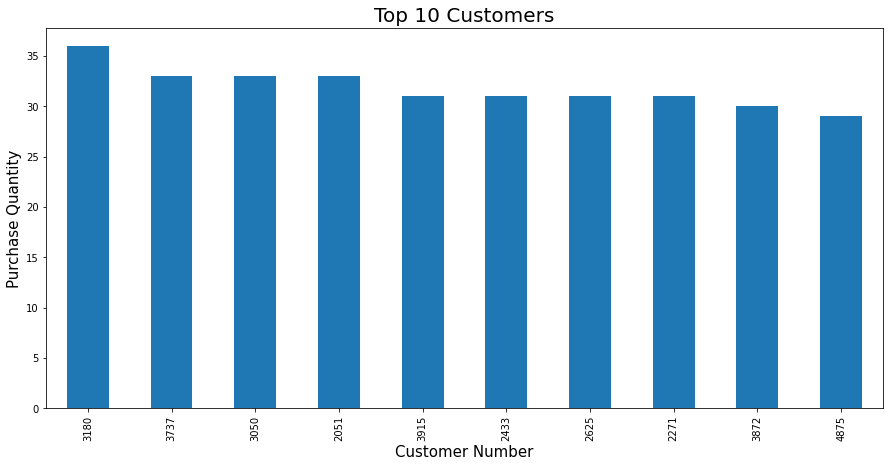

In [16]:
Top10Customers=groceries.groupby('Member_number').agg(PurchaseQuantity=('itemDescription','count')).sort_values(by='PurchaseQuantity',ascending=False)[0:10]

Top10Customers.plot(kind='bar',figsize=(15,7),legend=None)
plt.title('Top 10 Customers',fontsize=20)
plt.xlabel('Customer Number',fontsize=15)
plt.ylabel('Purchase Quantity',fontsize=15)
plt.show()

## Time Series Analysis

In [17]:
groceries.set_index('Date',inplace=True)

### Daily Sales 

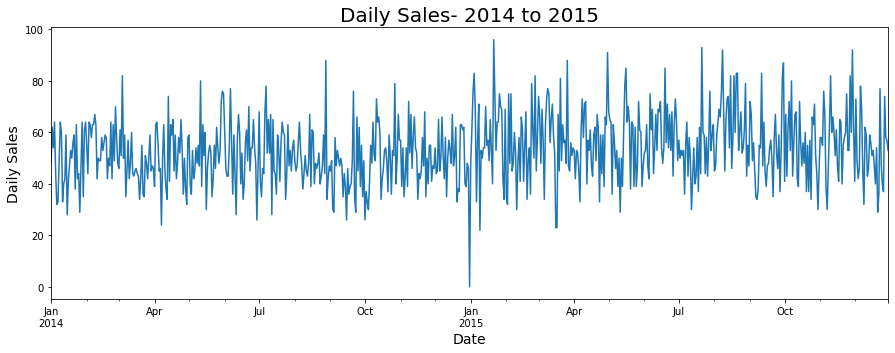

In [18]:
groceries.resample('D')[['itemDescription']].count().plot(kind='line',figsize=(15,5),legend=None)
plt.title('Daily Sales- 2014 to 2015',fontsize=20)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Daily Sales',fontsize=14)
plt.show()

### Monthly Sales- 2014 to 2015

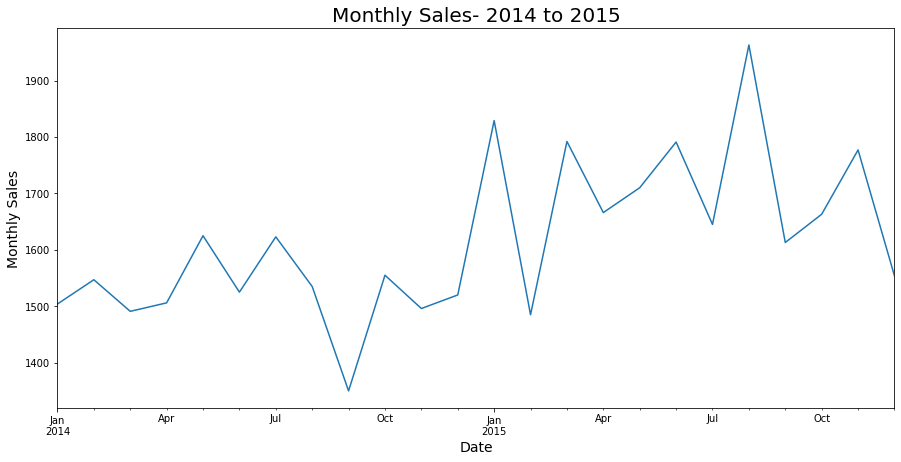

In [19]:
groceries.resample('M')[['itemDescription']].count().plot(kind='line',figsize=(15,7),legend=None )
plt.title('Monthly Sales- 2014 to 2015',fontsize=20)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Monthly Sales',fontsize=14)
plt.show()

#### Lets Have a Different View of the above Monthly Purchases- 2014 to 2015 Graph, to better compare the two years.

In [20]:
temp=groceries.groupby(['Years','Months'],as_index=False).agg(Sales=('itemDescription','count'))
temp.head()

,Years,Months,Sales
0,2014,Apr,1506
1,2014,Aug,1535
2,2014,Dec,1520
3,2014,Feb,1547
4,2014,Jan,1504


In [21]:
order_months=CategoricalDtype(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
temp['Months']=temp['Months'].astype(order_months)
temp=temp.sort_values(by='Months')
fig=px.line(temp,x='Months',y='Sales',color='Years')
fig.update_layout(title_text='Monthly Sales- 2014 to 2015',title_x=0.5,
                 title={'font': {'size':20}})

### Weekday Sales

In [22]:
temp2=groceries.groupby(['Years','Weekdays'],as_index=False).agg(Sales=('itemDescription','count'))

order_days=CategoricalDtype(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
temp2['Weekdays']=temp2['Weekdays'].astype(order_days)
temp2=temp2.sort_values(by='Weekdays')

fig=px.line(temp2,x='Weekdays',y='Sales',color='Years')
fig.update_layout(title_text='Weekday Sales- 2014 to 2015',title_x=0.5,
                 title={'font': {'size':20}})

### Sales Per Days of the Month

In [23]:
temp3=groceries.groupby(['Years','Days'],as_index=False).agg(Sales=('itemDescription','count'))

fig=px.line(temp3,x='Days',y='Sales',color='Years')
fig.update_layout(title_text='Sales Per Days of the Month',title_x=0.5,
                 title={'font':{'size':20}})
fig.show()

### Total Unique Customers Per Week

In [24]:
temp4= groceries.groupby(['Years','Weekdays'],as_index=False).agg(DailyCustomers=('Member_number','nunique'))

order_days=CategoricalDtype(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
temp4['Weekdays']=temp4['Weekdays'].astype(order_days)
temp4=temp4.sort_values(by='Weekdays')

fig=px.line(temp4,x='Weekdays',y='DailyCustomers',color='Years')
fig.update_layout(title_text='Weekday Customers- 2014 & 2015',title_x=0.5,
                 title={'font': {'size':20}})

### Average Number of Unique Customers Per Weekday

In [25]:
groceries=groceries.reset_index()

In [26]:
temp5= groceries.groupby([pd.Grouper(key='Date',freq='D'),'Years','Months','Weekdays'],as_index=False).agg(UniqueCustomers=('Member_number','nunique'))
temp5

,Years,Months,Weekdays,UniqueCustomers
0,2014,Jan,Wednesday,21
1,2014,Jan,Thursday,29
2,2014,Jan,Friday,24
3,2014,Jan,Saturday,28
4,2014,Jan,Sunday,20
...,...,...,...,...
723,2015,Dec,Saturday,15
724,2015,Dec,Sunday,21
725,2015,Dec,Monday,19
726,2015,Dec,Tuesday,22


In [27]:
temp6=temp5.groupby(['Years','Weekdays'],as_index=False)[['UniqueCustomers']].mean()

fig=px.bar(temp6,x='Weekdays',y='UniqueCustomers',color='Weekdays',facet_col='Years',
          category_orders={'Weekdays':['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']})
fig.update_layout(title_text='Avg Number of Unique Customers Per Weekday',title_x=0.5,
                 title={'font': {'size':20}},
                 showlegend=False)
fig.show()

**Across the board 2015 compared to 2014 has fewer average number of unique customers per weekday.**

### Customer Sales Per Weekday 

In [28]:
temp6=groceries.groupby([pd.Grouper(key='Date',freq='D'),'Years','Weekdays'],as_index=False).agg(Sales=('itemDescription','count'),Customers=('Member_number','nunique'))
temp6

,Years,Weekdays,Sales,Customers
0,2014,Wednesday,48,21
1,2014,Thursday,62,29
2,2014,Friday,54,24
3,2014,Saturday,64,28
4,2014,Sunday,44,20
...,...,...,...,...
723,2015,Saturday,37,15
724,2015,Sunday,74,21
725,2015,Monday,58,19
726,2015,Tuesday,57,22


In [29]:
temp7=temp6.groupby(['Years','Weekdays'],as_index=False).agg(Sales=('Sales','sum'),Customers=('Customers','sum')).eval('SalesPerCustomer=Sales/Customers').drop(columns=['Sales','Customers'])

fig=px.bar(temp7,x='Weekdays',y='SalesPerCustomer',color='Weekdays',facet_col='Years',
      category_orders={'Weekdays':['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']})

fig.update_layout(title_text='Weekday Sales Per Customer',title_x=0.5,
                 title={'font': {'size':20}},
                 showlegend=False)


fig.show()

**While 2014 had more average number of unique customers per weekday, 2015 has more sales per customer on a given weekday.**